In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
######################################################################
# CartPole ( https://www.gymlibrary.dev/environments/classic_control/cart_pole/ )
#=====================================================================
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

In [3]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [4]:
env.action_space

Discrete(2)

In [5]:
env.action_space.sample() # random action

0

In [6]:
# take a random action
observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
observation, reward, terminated, truncated, info

(array([ 0.00187759,  0.22870319, -0.02208624, -0.3405898 ], dtype=float32),
 1.0,
 False,
 False,
 {})

In [7]:
env_screen = env.render() # numpy.ndarray
env_screen.shape

(400, 600, 3)

In [8]:
env_screen

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [9]:
import gym
import numpy as np


# iteration
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()

total_reward = 0
terminated = False
MAX_ITERATION = 100
env_screens = []
i = 0
while not terminated and i < MAX_ITERATION:
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    env_screen = env.render() # numpy.ndarray
    env_screens.append(env_screen)
    total_reward += reward
    i += 1

env.close()
total_reward

20.0

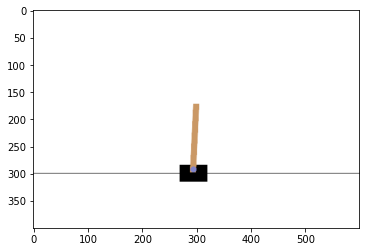

In [10]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

####################################################
# create an animation
#===================================================

fig, ax = plt.subplots()
im = ax.imshow(env_screens[0])

def update(i):
    im.set_data(env_screens[i])
    return (im)

animation = FuncAnimation(fig=fig, func=update, frames=len(env_screens), interval=100)
#plt.show()

# display the animation in the notebook
HTML(animation.to_jshtml())